# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [42]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

# show all observation-related columns/rows
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [43]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')

In [44]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.describe().T

,count,mean,std,min,25%,50%,75%,max
AGER_TYP,891221.0,-0.358435,1.198724,-1.0,-1.0,-1.0,-1.0,3.0
ALTERSKATEGORIE_GROB,891221.0,2.777398,1.068775,1.0,2.0,3.0,4.0,9.0
ANREDE_KZ,891221.0,1.522098,0.499512,1.0,1.0,2.0,2.0,2.0
CJT_GESAMTTYP,886367.0,3.632838,1.595021,1.0,2.0,4.0,5.0,6.0
FINANZ_MINIMALIST,891221.0,3.074528,1.321055,1.0,2.0,3.0,4.0,5.0
FINANZ_SPARER,891221.0,2.821039,1.464749,1.0,1.0,3.0,4.0,5.0
FINANZ_VORSORGER,891221.0,3.401106,1.322134,1.0,3.0,3.0,5.0,5.0
FINANZ_ANLEGER,891221.0,3.033328,1.529603,1.0,2.0,3.0,5.0,5.0
FINANZ_UNAUFFAELLIGER,891221.0,2.874167,1.486731,1.0,2.0,3.0,4.0,5.0
FINANZ_HAUSBAUER,891221.0,3.075121,1.353248,1.0,2.0,3.0,4.0,5.0


In [45]:
azdias.head(16).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
AGER_TYP,-1,-1,-1,2,-1,3,-1,-1,-1,-1,0,-1,-1,-1,-1,1
ALTERSKATEGORIE_GROB,2,1,3,4,3,1,2,1,3,3,3,2,3,1,3,4
ANREDE_KZ,1,2,2,2,1,2,2,1,1,2,2,1,1,2,1,2
CJT_GESAMTTYP,2,5,3,2,5,2,5,3,3,4,1,6,6,5,6,4
FINANZ_MINIMALIST,3,1,1,4,4,3,1,3,4,2,2,3,5,1,3,4
FINANZ_SPARER,4,5,4,2,3,1,5,3,4,4,2,4,3,4,4,1
FINANZ_VORSORGER,3,2,1,5,4,5,1,4,2,2,5,3,4,3,3,5
FINANZ_ANLEGER,5,5,2,2,1,2,5,1,4,3,3,5,2,5,5,1
FINANZ_UNAUFFAELLIGER,5,4,3,1,3,2,4,3,2,5,1,5,4,5,5,1
FINANZ_HAUSBAUER,3,5,5,2,2,5,3,2,2,4,5,3,1,2,3,4


In [46]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [47]:
feat_info.shape

(85, 4)

In [48]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


----
#### Derek's Notes

- There are 891221 observations and 85 features in the original dataset
- Hard to understand what the features are
- There are missing values
- Values range is all over place, we may need to use a scaler later
- there are float, integer and object (strings?) - 3 types of data
---

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [49]:
# Identify missing or unknown data values and convert them to NaNs.
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,KK_KUNDENTYP,person,ordinal,[-1]
freq,1,43,49,26


In [50]:
feat_info.head(100)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [51]:
# total missing values
azdias.isnull().sum().sum()

4896838

In [52]:
for indx in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip(']')
    missing_or_unknown = missing_or_unknown.split(sep=',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)

In [53]:
# total number of missing values after conversion is 
azdias.isnull().sum().sum()

8373929

In [54]:
# we can see that the missing or unknow values specified in the feat info are now replaced with NaN
azdias.head(16).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
AGER_TYP,NaN,NaN,NaN,2,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
ALTERSKATEGORIE_GROB,2,1,3,4,3,1,2,1,3,3,3,2,3,1,3,4
ANREDE_KZ,1,2,2,2,1,2,2,1,1,2,2,1,1,2,1,2
CJT_GESAMTTYP,2,5,3,2,5,2,5,3,3,4,1,6,6,5,6,4
FINANZ_MINIMALIST,3,1,1,4,4,3,1,3,4,2,2,3,5,1,3,4
FINANZ_SPARER,4,5,4,2,3,1,5,3,4,4,2,4,3,4,4,1
FINANZ_VORSORGER,3,2,1,5,4,5,1,4,2,2,5,3,4,3,3,5
FINANZ_ANLEGER,5,5,2,2,1,2,5,1,4,3,3,5,2,5,5,1
FINANZ_UNAUFFAELLIGER,5,4,3,1,3,2,4,3,2,5,1,5,4,5,5,1
FINANZ_HAUSBAUER,3,5,5,2,2,5,3,2,2,4,5,3,1,2,3,4


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [55]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

def extract_columns_with_nan(df):

    # Extract columns with NaNs
    columns_with_nans = df.isnull().sum()[df.isnull().sum() > 0]
    
    # Calculate percentage of NaN for each column
    dic_nan = { 'total_missing_values': columns_with_nans.values, 'percent_missing': np.round(columns_with_nans.values * 100 /df.shape[0], 2)}
    
    # Build a dataframe including only columns with NaNs
    df_nan = pd.DataFrame(data=dic_nan, index=columns_with_nans.index)

    # Sort by percentage
    df_nan.sort_values(by='percent_missing', ascending=False, inplace=True)

    return df_nan


azdias_nan = extract_columns_with_nan(azdias)
azdias_nan

,total_missing_values,percent_missing
TITEL_KZ,889061,99.76
AGER_TYP,685843,76.96
KK_KUNDENTYP,584612,65.60
KBA05_BAUMAX,476524,53.47
GEBURTSJAHR,392318,44.02
ALTER_HH,310267,34.81
KKK,158064,17.74
REGIOTYP,158064,17.74
W_KEIT_KIND_HH,147988,16.61
KBA05_ANTG3,133324,14.96


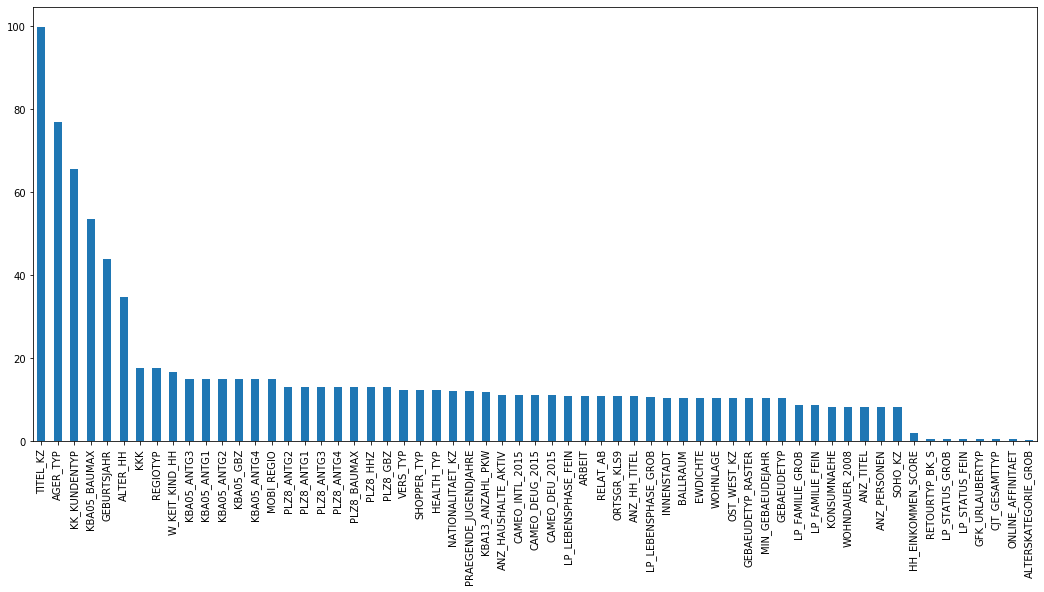

In [56]:
# Investigate patterns in the amount of missing data in each column.
azdias_nan.percent_missing.plot.bar(figsize=(18, 8));

In [57]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
percent_missing_20 = azdias_nan.percent_missing[azdias_nan.percent_missing>20]

percent_missing_20

TITEL_KZ        99.76
AGER_TYP        76.96
KK_KUNDENTYP    65.60
KBA05_BAUMAX    53.47
GEBURTSJAHR     44.02
ALTER_HH        34.81
Name: percent_missing, dtype: float64

In [58]:
drop_these = percent_missing_20.index.tolist()
print('These columns have more than 20% missing data, and will be dropped:{}'.format(drop_these))

These columns have more than 20% missing data, and will be dropped:['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']


In [59]:
azdias = azdias.drop(drop_these, axis=1)

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, REGIOTYP to ALTERSKATEGORIE_GROB
Data columns (total 2 columns):
total_missing_values    55 non-null int64
percent_missing         55 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.3+ KB


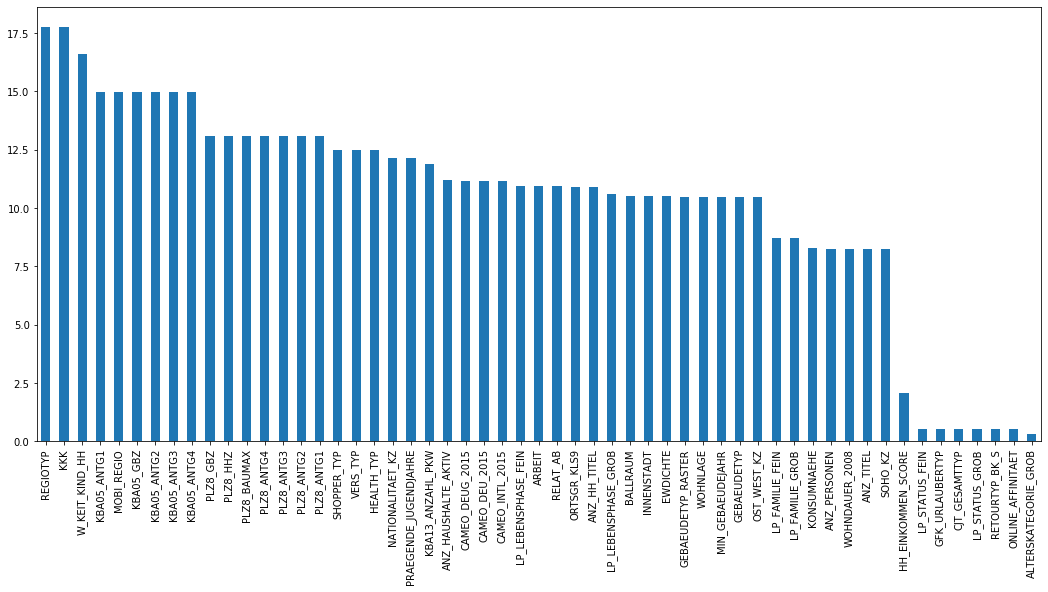

In [60]:
azdias_nan = extract_columns_with_nan(azdias)
azdias_nan.percent_missing.plot.bar(figsize=(18, 8));
azdias_nan.info()

In [61]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS_GROB           

#### Discussion 1.1.2: Assess Missing Data in Each Column
---
#### Derek's Notes

- Most columns have less than 20% missing data. 
- There are 6 columns with more than 20% missing data. I have dropped them. 
- Now there are 55 columns with missing data, all of them has less than 18% of data missing.
- columns dropped : 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'.



-------

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [62]:
# How much data is missing in each row of the dataset?
missing_data_by_row = azdias.isnull().sum(axis=1)
missing_data_by_row.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

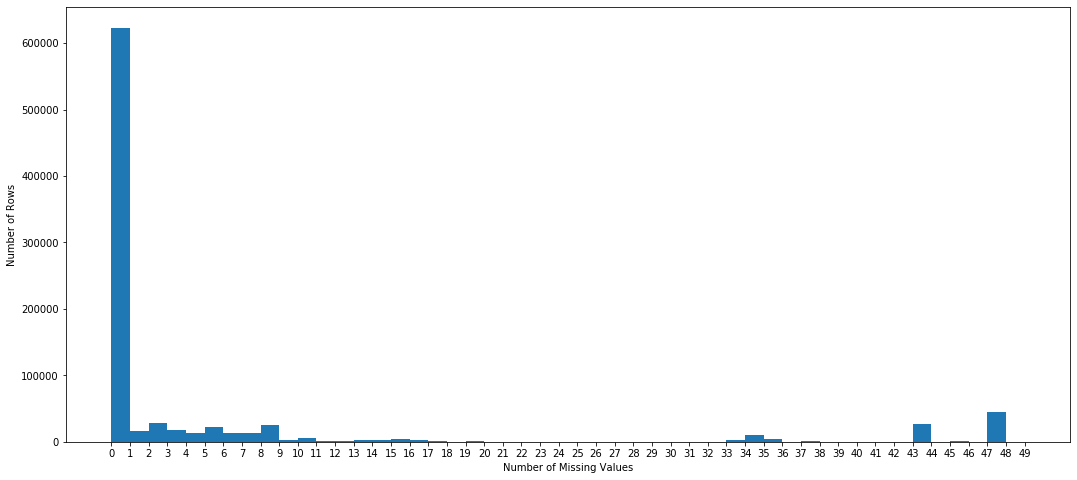

In [63]:
plt.figure(figsize=(18, 8))
plt.xticks(np.arange(0, 50, 1))
bins=np.arange(0, 50, 1)
plt.hist(missing_data_by_row, bins=bins)
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')
plt.show()

In [64]:
# What is the ratio of rows without missing data?
rows_total       = missing_data_by_row.count()
rows_no_nans     = missing_data_by_row[missing_data_by_row == 0].count()
rows_with_nans   = missing_data_by_row[missing_data_by_row != 0].count()
percent_no_nans  = rows_no_nans/rows_total*100
percent_with_nans= rows_with_nans/rows_total*100

print('Number of all rows:', rows_total)
print('Percent of rows with no missing values:', percent_no_nans)
print('Percent of rows with missing values:', percent_with_nans)

Number of all rows: 891221
Percent of rows with no missing values: 69.9275488346886
Percent of rows with missing values: 30.07245116531141


In [65]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

In [66]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

## randomly select 5 columns for comparison:
    
np.random.seed(23456)
sample_columns = np.random.choice(azdias.columns, 5).tolist()
print(sample_columns)

['RELAT_AB', 'ANZ_PERSONEN', 'SEMIO_TRADV', 'ONLINE_AFFINITAET', 'NATIONALITAET_KZ']


In [67]:
# Add information about number of NaN for each row to the master dataset
azdias = azdias.assign(NAN_NUM=pd.Series(missing_data_by_row.values))
azdias.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NAN_NUM
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0
6,2.0,2,5.0,1,5,1,5,4,3,4,12.0,0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,10.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1.0,0.0,1.0,4,1.0,0.0,6.0,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0
7,1.0,1,3.0,3,3,4,1,3,2,5,9.0,0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0.0,0.0,1.0,1,1.0,0.0,4.0,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0,0
8,3.0,1,3.0,4,4,2,4,2,2,6,3.0,1,3.0,10.0,3.0,1.0,1.0,10.0,5.0,1.0,11.0,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3.0,0.0,2.0,6,1.0,0.0,3.0,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,0
9,3.0,2,4.0,2,4,2,3,5,4,1,12.0,1,2.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3.0,0.0,2.0,4,1.0,0.0,4.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,0


In [68]:
# Split the main dataset into two for data distributions comparison for selected columns
split_value = 2
high_nan_rows = azdias[azdias.NAN_NUM >= split_value].copy()
low_nan_rows = azdias[azdias.NAN_NUM < split_value].copy()

In [69]:
# Select randomly 5 rows from high and low nan count subsets for comparison
sample_high_nan_rows = high_nan_rows.sample(5)
sample_high_nan_rows

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NAN_NUM
247315,3.0,2,1.0,5,2,3,5,5,1,3,2.0,1,3.0,18.0,5.0,2.0,2.0,10.0,5.0,1.0,11.0,2.0,2,3,3,2,2,1,6,3,4,5,6,5,4,3,2.0,0.0,1.0,2,2.0,0.0,1.0,3.0,9.0,1.0,0.0,3.0,2.0,2001.0,W,2.0,4,4A,22,3.0,0.0,0.0,0.0,5.0,6.0,2.0,6.0,3.0,NaN,5.0,5.0,NaN,354.0,3.0,1.0,0.0,0.0,1.0,2.0,3.0,2.0,5.0,3.0,2
78239,3.0,2,5.0,1,4,1,4,4,3,1,11.0,0,3.0,4.0,1.0,1.0,1.0,4.0,2.0,1.0,14.0,2.0,5,4,3,2,4,4,6,3,4,4,4,7,5,4,2.0,0.0,1.0,5,1.0,0.0,5.0,NaN,9.0,9.0,0.0,3.0,3.0,1995.0,W,5.0,6,6B,43,0.0,0.0,0.0,1.0,2.0,5.0,5.0,4.0,4.0,NaN,2.0,2.0,NaN,1018.0,2.0,3.0,2.0,2.0,4.0,5.0,3.0,2.0,4.0,3.0,3
481249,3.0,1,2.0,5,1,5,1,1,2,2,8.0,0,1.0,12.0,3.0,1.0,1.0,9.0,4.0,1.0,3.0,5.0,3,6,4,6,7,1,4,5,5,5,2,3,4,4,1.0,0.0,1.0,6,1.0,0.0,3.0,6.0,9.0,2.0,0.0,1.0,4.0,1994.0,W,0.0,3,3B,23,NaN,NaN,NaN,NaN,NaN,6.0,4.0,8.0,4.0,NaN,NaN,4.0,NaN,1500.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,4.0,3.0,8
640807,1.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47
133909,3.0,2,3.0,1,5,3,5,4,5,1,9.0,0,NaN,21.0,6.0,4.0,3.0,2.0,1.0,NaN,14.0,1.0,3,4,7,5,2,5,3,5,5,4,5,6,7,3,NaN,0.0,NaN,4,1.0,0.0,6.0,1.0,4.0,10.0,0.0,1.0,4.0,1992.0,W,4.0,7,7D,54,0.0,3.0,2.0,0.0,3.0,2.0,4.0,4.0,5.0,4.0,2.0,3.0,6.0,472.0,2.0,4.0,3.0,0.0,3.0,3.0,3.0,2.0,4.0,3.0,4


In [70]:
sample_low_nan_rows = low_nan_rows.sample(5)
sample_low_nan_rows

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NAN_NUM
47787,1.0,2,4.0,1,5,2,4,3,5,1,4.0,0,3.0,14.0,4.0,2.0,2.0,2.0,1.0,1.0,14.0,1.0,3,4,5,4,3,2,4,6,7,7,7,6,7,6,1.0,0.0,2.0,5,2.0,0.0,5.0,3.0,5.0,10.0,0.0,1.0,4.0,1992.0,W,3.0,8,8B,41,3.0,2.0,0.0,0.0,3.0,1.0,6.0,3.0,4.0,3.0,3.0,4.0,6.0,365.0,4.0,2.0,1.0,0.0,1.0,3.0,4.0,4.0,8.0,3.0,0
680118,4.0,1,4.0,5,1,5,1,2,2,5,10.0,1,1.0,20.0,5.0,2.0,2.0,10.0,5.0,1.0,6.0,5.0,6,4,5,1,7,7,3,4,3,3,3,2,4,4,3.0,0.0,1.0,1,2.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,4.0,1992.0,W,1.0,2,2D,14,3.0,0.0,0.0,0.0,5.0,3.0,5.0,5.0,4.0,2.0,5.0,3.0,3.0,837.0,2.0,3.0,2.0,1.0,1.0,4.0,4.0,3.0,4.0,3.0,0
30118,4.0,2,1.0,2,2,5,2,1,5,6,12.0,0,1.0,6.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,5.0,2,2,1,2,5,5,7,1,3,6,6,6,2,1,1.0,0.0,2.0,3,1.0,0.0,6.0,6.0,9.0,13.0,0.0,3.0,1.0,1994.0,O,5.0,9,9C,51,0.0,0.0,0.0,2.0,1.0,1.0,6.0,1.0,2.0,4.0,1.0,0.0,6.0,304.0,1.0,1.0,2.0,2.0,5.0,5.0,1.0,4.0,9.0,3.0,1
92333,3.0,1,2.0,3,3,3,3,1,4,6,10.0,0,3.0,5.0,2.0,1.0,1.0,1.0,1.0,2.0,8.0,5.0,6,4,4,4,5,6,4,6,2,5,5,2,5,2,2.0,0.0,2.0,3,1.0,0.0,6.0,5.0,9.0,46.0,1.0,3.0,1.0,1992.0,O,4.0,9,9C,51,1.0,0.0,0.0,1.0,3.0,1.0,6.0,2.0,2.0,3.0,1.0,0.0,6.0,341.0,1.0,1.0,2.0,2.0,5.0,3.0,1.0,4.0,9.0,3.0,0
422934,3.0,1,6.0,2,5,2,3,4,4,4,5.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,4.0,6,4,4,4,5,6,4,5,2,5,5,3,5,4,2.0,0.0,2.0,5,1.0,0.0,6.0,6.0,2.0,9.0,1.0,1.0,2.0,1992.0,W,1.0,9,9C,51,0.0,2.0,2.0,0.0,3.0,6.0,5.0,3.0,5.0,2.0,1.0,5.0,3.0,210.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,4.0,7.0,5.0,0


In [71]:
# Compare incomplete and complete data for a given column
def compare_dist_for_a_column(df, column_name, split_value):
    fig = plt.figure(figsize=(15, 6))
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Incomplete - More Missing Than Split Value')
    sns.countplot(df.loc[df.NAN_NUM >= split_value, column_name])

    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Complete - Less Missing Than Split Value')
    sns.countplot(df.loc[~df.NAN_NUM < split_value, column_name])

    fig.suptitle(column_name)
    plt.show();
    
    # Computes the Kolmogorov-Smirnov statistic on 2 samples.
    # This is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution.
    # If the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.
    # If the p-value is low, then we can reject the hypothesis that the distributions of the two samples are the same.
    # for more see: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ks_2samp.html
    print(stats.ks_2samp(df.loc[df.NAN_NUM >= split_value, column_name], df.loc[~df.NAN_NUM < split_value, column_name]))

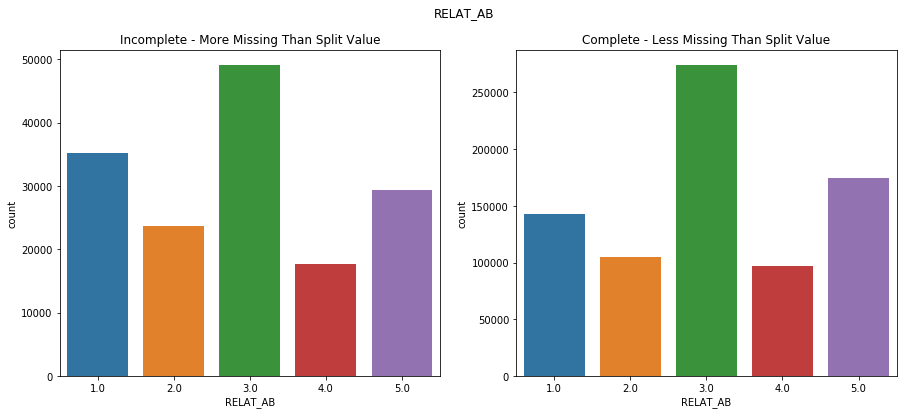

Ks_2sampResult(statistic=0.2767288264961325, pvalue=0.0)


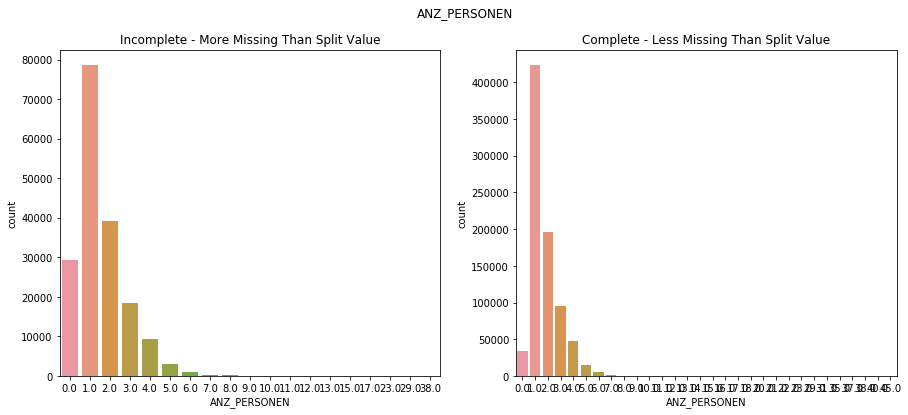

Ks_2sampResult(statistic=0.2088794260582807, pvalue=0.0)


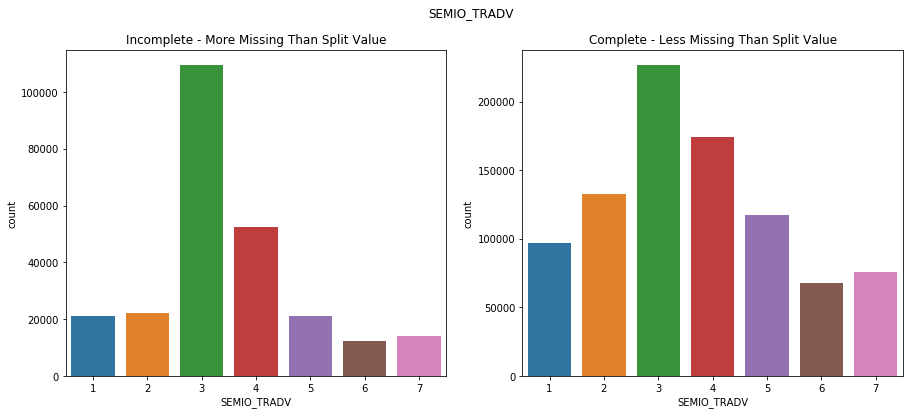

Ks_2sampResult(statistic=0.10469713686428705, pvalue=0.0)


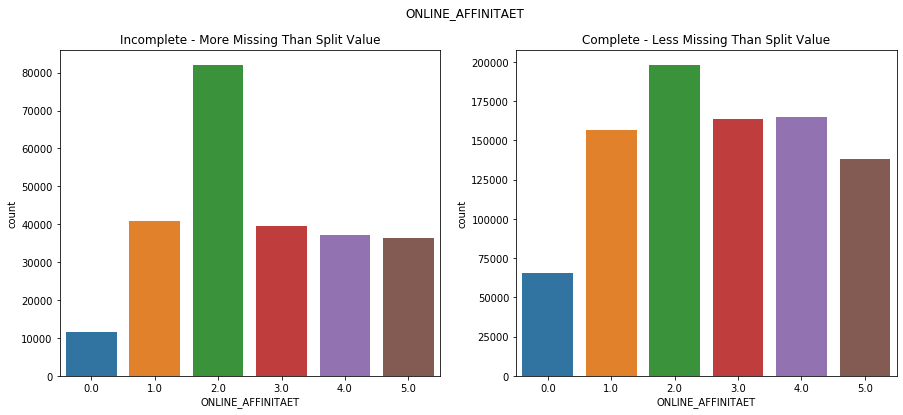

Ks_2sampResult(statistic=0.06096170069590223, pvalue=0.0)


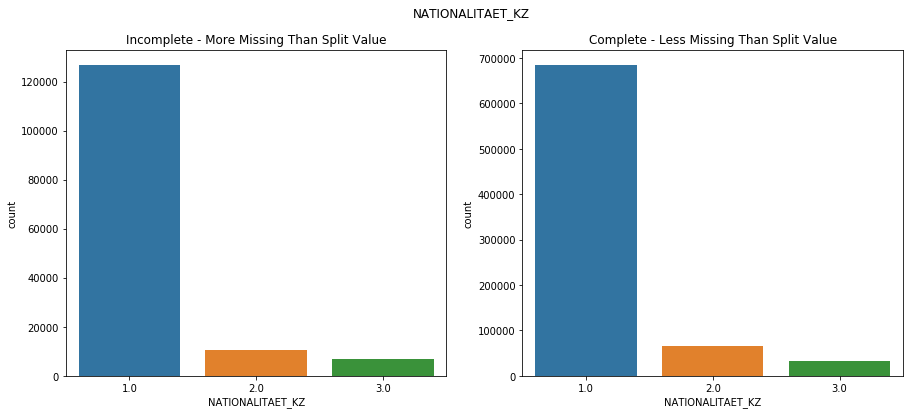

Ks_2sampResult(statistic=0.3078190792495875, pvalue=0.0)


In [72]:
for col in sample_columns:
    compare_dist_for_a_column(azdias, col, split_value)

#### Discussion 1.1.3: Assess Missing Data in Each Row

---
#### Derek's notes:
- First, I see that Y axis scales are different for incomplete and complete rows.

- aside from 'SEMIO_TRADV', 'ONLINE_AFFINITAET', the complete and incomplete features looks similar in distribution between data missing many values and the data missing a couple or no missing values. Though I used Kolmogorov–Smirnov to see if the distributions of the two samples are the same, and I see that pvalues are close to 0, meaning that they are not the same.

- I will drop all rows with missing data. Because I do not know how the missing data should be handled (the values are not continuous)

- The missing data is about 30% of all data. Excluding a big portion of population may have impact on the analysis result. However, there are still more than 623k rows left with complete data which will hopefully be okay.
---

In [73]:
# Remove all rows with missing values
print(azdias.shape[0])
azdias = azdias[azdias.NAN_NUM < 1]
print(azdias.shape[0])

891221
623209


In [74]:
# Missing data in the dataset
azdias.isnull().sum(axis=1).sum()

0

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [75]:
# How many features are there of each data type?
feat_info.type.value_counts()

features = list(azdias.columns)
feat_info_clean = feat_info[feat_info['attribute'].isin(features)]
feat_info_clean.type.value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [76]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Select categorical features names
cat_features = feat_info_clean[feat_info_clean["type"]=="categorical"]["attribute"]
print(cat_features)

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object


In [77]:
# Split categorical variables into binary or multi buckets
binary_features = []
multi_level_features=[]
for feature in cat_features:
    if (len(azdias[feature].unique())==2):
        binary_features.append(feature)
    elif (len(azdias[feature].unique())>2):
        multi_level_features.append(feature)

print('Binary features:')
print(binary_features)
print( )
print('Multi-level features:')
print(multi_level_features)

Binary features:
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

Multi-level features:
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [78]:
# Re-encode categorical variable(s) to be kept in the analysis.
for col in binary_features:
    print(azdias[col].value_counts())

2    318591
1    304618
Name: ANREDE_KZ, dtype: int64
0    476988
1    146221
Name: GREEN_AVANTGARDE, dtype: int64
0.0    617913
1.0      5296
Name: SOHO_KZ, dtype: int64
2.0    331723
1.0    291486
Name: VERS_TYP, dtype: int64
W    490879
O    132330
Name: OST_WEST_KZ, dtype: int64


In [79]:
# replacing values, leaving GREEN_AVANTGARDE alone since it is already in the right format
azdias['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)
azdias['SOHO_KZ'].replace([0.0, 1.0], [0, 1], inplace=True)
azdias['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

In [80]:
for col in binary_features:
    print(azdias[col].value_counts())

1    318591
0    304618
Name: ANREDE_KZ, dtype: int64
0    476988
1    146221
Name: GREEN_AVANTGARDE, dtype: int64
0.0    617913
1.0      5296
Name: SOHO_KZ, dtype: int64
1.0    331723
0.0    291486
Name: VERS_TYP, dtype: int64
1    490879
0    132330
Name: OST_WEST_KZ, dtype: int64


In [81]:
for col in multi_level_features:
    print(azdias[col].value_counts())

4.0    160908
3.0    119004
2.0    113203
5.0     79854
6.0     77273
1.0     72967
Name: CJT_GESAMTTYP, dtype: int64
6    240292
1    146234
5     88119
2     79302
4     44630
3     24632
Name: FINANZTYP, dtype: int64
12.0    98076
10.0    81624
8.0     69405
11.0    60164
5.0     57326
4.0     51615
3.0     44233
9.0     41272
1.0     39929
7.0     31423
2.0     27430
6.0     20712
Name: GFK_URLAUBERTYP, dtype: int64
1.0     325104
10.0    108290
2.0      80801
11.0     41248
8.0      16764
7.0      14077
4.0       9174
5.0       9123
9.0       8831
6.0       6211
3.0       3586
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    325104
5.0    158369
2.0     80801
4.0     37052
3.0     21883
Name: LP_FAMILIE_GROB, dtype: int64
1.0     175564
9.0      97350
10.0     93471
2.0      81016
3.0      58334
4.0      58008
6.0      23303
5.0      17870
8.0      10742
7.0       7551
Name: LP_STATUS_FEIN, dtype: int64
1.0    256580
2.0    134212
4.0    108092
5.0     93471
3.0     30854
Name: LP_STATU

In [82]:
# one-hot encoder
azdias = pd.get_dummies(azdias, columns=multi_level_features)

In [83]:
azdias.head().T

,1,2,4,5,6
ALTERSKATEGORIE_GROB,1,3,3,1,2
ANREDE_KZ,1,1,0,1,1
FINANZ_MINIMALIST,1,1,4,3,1
FINANZ_SPARER,5,4,3,1,5
FINANZ_VORSORGER,2,1,4,5,1
FINANZ_ANLEGER,5,2,1,2,5
FINANZ_UNAUFFAELLIGER,4,3,3,2,4
FINANZ_HAUSBAUER,5,5,2,5,3
GREEN_AVANTGARDE,0,1,0,0,0
HEALTH_TYP,3,3,3,3,2


#### Discussion 1.2.1: Re-Encode Categorical Features
---
#### Derek's notes

- binary categorical features now have values 0 or 1.
- muti-level categorical features are now treated with one-hot-encoder.

-----

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [84]:
# Select mixed features names
mixed_features = feat_info_clean[feat_info_clean["type"]=="mixed"]["attribute"]
print(mixed_features)

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object


In [85]:
azdias[mixed_features].sample(15).T

,436275,35919,138075,83815,142348,389132,817040,427258,763105,407055,783667,353944,670000,7011,412943
LP_LEBENSPHASE_FEIN,23,2,10,1,30,34,6,37,26,1,24,5,11,10,24
LP_LEBENSPHASE_GROB,6,1,3,1,9,11,2,12,8,1,7,2,3,3,7
PRAEGENDE_JUGENDJAHRE,10,10,11,14,14,12,5,8,10,14,14,8,8,12,14
WOHNLAGE,7,3,4,4,3,7,3,2,3,3,3,3,7,4,5
CAMEO_INTL_2015,24,41,41,51,33,43,35,43,22,41,22,54,13,41,51
PLZ8_BAUMAX,1,4,5,1,2,1,3,1,1,5,1,4,1,4,2


In [86]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Generation 
# create a dictionary
generations = {0: [1, 2], # 40s
               1: [3, 4], # 50s
               2: [5, 6, 7], # 60s
               3: [8, 9], # 70s
               4: [10, 11, 12, 13], # 80s
               5: [14, 15]} # 90s

def classify_generation(value):
    for key, values in generations.items():
        if pd.isnull(value):
            return np.nan
        elif value in values:
                return key
    
# Movement 
mainstream = [1, 3, 5, 8, 10, 12, 14]

def classify_movement(value):
    if pd.isnull(value):
        return np.nan
    elif value in mainstream:
        return 1
    else:
        return 0
    
# Engineer generation column
azdias['PRAEGENDE_JUGENDJAHRE_GEN'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(classify_generation)

# Engineer movement column
azdias['PRAEGENDE_JUGENDJAHRE_MOV'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(classify_movement)

In [87]:
azdias.sample(15).T

,610255,257324,759014,274617,245823,394290,583030,585385,558156,418733,61069,564959,538397,1645,275613
ALTERSKATEGORIE_GROB,3,4,4,1,4,4,3,3,3,2,3,2,4,4,1
ANREDE_KZ,0,1,1,0,0,1,0,1,0,1,0,1,1,0,0
FINANZ_MINIMALIST,5,2,3,5,5,2,5,1,5,1,3,4,4,4,2
FINANZ_SPARER,3,3,1,2,1,1,1,4,2,4,3,2,2,1,5
FINANZ_VORSORGER,3,3,5,3,5,5,5,2,4,1,4,4,5,5,3
FINANZ_ANLEGER,4,3,2,3,1,3,1,3,2,5,4,4,3,1,5
FINANZ_UNAUFFAELLIGER,1,3,1,2,1,1,1,4,3,2,1,2,1,2,4
FINANZ_HAUSBAUER,1,3,5,1,3,5,2,4,1,5,2,2,3,5,2
GREEN_AVANTGARDE,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1
HEALTH_TYP,3,2,2,2,1,2,3,2,3,2,3,2,2,2,1


In [88]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# first digit -> wealth
# second digit -> life stage

# Wealth 
def classify_wealth(value):
    # In case value is NaN
    if pd.isnull(value):
        return np.nan
    else:
        # Return first digit
        return int(str(value)[0])

# Life stage
def classify_lifestage(value):
    # In case value is NaN
    if pd.isnull(value):
        return np.nan
    else:
        # Return second digit
        return int(str(value)[1])

    
# Engineer wealth column
azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'].apply(classify_wealth)

# Engineer life stage column
azdias['CAMEO_INTL_2015_LIFESTAGE'] = azdias['CAMEO_INTL_2015'].apply(classify_lifestage)

In [89]:
# Remove unneeded and the rest of mixed columns (as per instruction above)
azdias = azdias.drop(mixed_features, axis=1)
azdias.sample(15).T

,809716,172351,434947,154136,27261,696774,56450,821901,567774,759006,745644,809399,215766,318241,711219
ALTERSKATEGORIE_GROB,1.0,4.0,3.0,3.0,3.0,3.0,3.0,2.0,4.0,3.0,4.0,4.0,1.0,1.0,3.0
ANREDE_KZ,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
FINANZ_MINIMALIST,1.0,2.0,4.0,5.0,1.0,3.0,4.0,1.0,2.0,2.0,5.0,5.0,1.0,4.0,1.0
FINANZ_SPARER,5.0,1.0,1.0,2.0,5.0,1.0,2.0,5.0,1.0,1.0,1.0,3.0,5.0,3.0,4.0
FINANZ_VORSORGER,2.0,5.0,5.0,4.0,2.0,5.0,4.0,1.0,5.0,5.0,5.0,4.0,2.0,2.0,2.0
FINANZ_ANLEGER,5.0,3.0,1.0,2.0,4.0,1.0,2.0,4.0,2.0,1.0,1.0,4.0,5.0,3.0,2.0
FINANZ_UNAUFFAELLIGER,3.0,1.0,2.0,3.0,4.0,1.0,3.0,4.0,2.0,1.0,2.0,2.0,4.0,5.0,5.0
FINANZ_HAUSBAUER,5.0,5.0,4.0,1.0,5.0,5.0,2.0,5.0,5.0,5.0,2.0,1.0,5.0,2.0,4.0
GREEN_AVANTGARDE,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
HEALTH_TYP,3.0,2.0,3.0,3.0,3.0,3.0,3.0,2.0,1.0,2.0,1.0,2.0,1.0,3.0,3.0


#### Discussion 1.2.2: Engineer Mixed-Type Features
---
#### Derek's notes

- There were 6 mixed-type features in the dataset. 
- I engineered 4 new features:
- 2 decode PRAEGENDE_JUGENDJAHRE
- 2 to decode CAMEO_INTL_2015. 
- The new features are ordinal, and therefore don't need to be one-hot-encoded. 
- Removed the rest of the mixed features
-------

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [90]:
azdias.head(20).T

,1,2,4,5,6,7,8,9,10,19,21,22,27,28,31,32,33,36,37,38
ALTERSKATEGORIE_GROB,1.0,3.0,3.0,1.0,2.0,1.0,3.0,3.0,3.0,3.0,2.0,1.0,3.0,3.0,2.0,1.0,2.0,3.0,4.0,2.0
ANREDE_KZ,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
FINANZ_MINIMALIST,1.0,1.0,4.0,3.0,1.0,3.0,4.0,2.0,2.0,5.0,3.0,1.0,3.0,3.0,1.0,5.0,2.0,2.0,5.0,3.0
FINANZ_SPARER,5.0,4.0,3.0,1.0,5.0,3.0,4.0,4.0,2.0,2.0,4.0,5.0,3.0,2.0,5.0,4.0,2.0,3.0,1.0,3.0
FINANZ_VORSORGER,2.0,1.0,4.0,5.0,1.0,4.0,2.0,2.0,5.0,3.0,1.0,3.0,4.0,4.0,2.0,2.0,4.0,4.0,5.0,1.0
FINANZ_ANLEGER,5.0,2.0,1.0,2.0,5.0,1.0,4.0,3.0,3.0,1.0,2.0,5.0,1.0,3.0,3.0,3.0,1.0,3.0,1.0,4.0
FINANZ_UNAUFFAELLIGER,4.0,3.0,3.0,2.0,4.0,3.0,2.0,5.0,1.0,3.0,5.0,5.0,2.0,3.0,5.0,4.0,3.0,2.0,1.0,4.0
FINANZ_HAUSBAUER,5.0,5.0,2.0,5.0,3.0,2.0,2.0,4.0,5.0,1.0,1.0,5.0,2.0,2.0,4.0,1.0,4.0,3.0,3.0,2.0
GREEN_AVANTGARDE,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
HEALTH_TYP,3.0,3.0,3.0,3.0,2.0,1.0,3.0,2.0,2.0,3.0,2.0,2.0,3.0,3.0,1.0,1.0,2.0,2.0,2.0,2.0


In [91]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Remove NAN_NUM column
azdias = azdias.drop(['NAN_NUM'], axis=1)

# Check
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Columns: 189 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_LIFESTAGE
dtypes: float64(37), int64(27), uint8(125)
memory usage: 383.3 MB


In [92]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [93]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # convert missing value codes into NaNs, ...
    for indx in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[')
        missing_or_unknown = missing_or_unknown.strip(']')
        missing_or_unknown = missing_or_unknown.split(sep=',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df = df.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)    
    
    # remove selected columns and rows, ...
    
    # remove columns with 20% nans
    def remove_columns_with_nans(df):
        columns_with_nans = df.isnull().sum()[df.isnull().sum() > 0]
        dic_nan = { 'total_missing_values': columns_with_nans.values, 'percent_missing': np.round(columns_with_nans.values * 100 /df.shape[0], 2)}
        df_nan = pd.DataFrame(data=dic_nan, index=columns_with_nans.index)
        df_nan.sort_values(by='percent_missing', ascending=False, inplace=True)
        percent_missing_20 = df_nan.percent_missing[df_nan.percent_missing>20]
        drop_these = percent_missing_20.index.tolist()
        df = df.drop(drop_these, axis=1)
        return df
        
    df = remove_columns_with_nans(df)
    
    # remove all rows with nans
    def remove_rows_with_nans(df):
        missing_data_by_row = df.isnull().sum(axis=1)
        df = df.assign(NAN_NUM=pd.Series(missing_data_by_row.values))
        df = df[df.NAN_NUM < 1]
        return df
    
    df = remove_rows_with_nans(df)
    
    # select, re-encode, and engineer column values.
    def recode_and_engineer(df):
        feat_info.type.value_counts()
        features = list(df.columns)
        feat_info_clean = feat_info[feat_info['attribute'].isin(features)]
        
        # deal with cat features - binary and multi
        cat_features = feat_info_clean[feat_info_clean["type"]=="categorical"]["attribute"]
        binary_features = []
        multi_level_features=[]
        for feature in cat_features:
            if (len(df[feature].unique())==2):
                binary_features.append(feature)
            elif (len(df[feature].unique())>2):
                multi_level_features.append(feature)
        if ['ANREDE_KZ'] in features:
            df['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)
    
        if ['SOHO_KZ'] in features:
            df['SOHO_KZ'].replace([0.0, 1.0], [0, 1], inplace=True)
    
        if ['VERS_TYP'] in features:
            df['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
    
        if ['OST_WEST_KZ'] in features:
            df['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
    
        df = pd.get_dummies(df, columns=multi_level_features)
        
        
        # deal with mixed features
        mixed_features = feat_info_clean[feat_info_clean["type"]=="mixed"]["attribute"]
        if ['PRAEGENDE_JUGENDJAHRE'] in features:
        # engineer "PRAEGENDE_JUGENDJAHRE"
        # Generation # create a dictionary
            generations = {0: [1, 2], # 40s
                           1: [3, 4], # 50s
                           2: [5, 6, 7], # 60s
                           3: [8, 9], # 70s
                           4: [10, 11, 12, 13], # 80s
                           5: [14, 15]} # 90s
            def classify_generation(value):
                for key, values in generations.items():
                    if pd.isnull(value):
                        return np.nan
                    elif value in values:
                        return key
            # Movement 
            mainstream = [1, 3, 5, 8, 10, 12, 14]
            def classify_movement(value):
                if pd.isnull(value):
                    return np.nan
                elif value in mainstream:
                    return 1
                else:
                    return 0
            df['PRAEGENDE_JUGENDJAHRE_GEN'] = df['PRAEGENDE_JUGENDJAHRE'].apply(classify_generation)
            df['PRAEGENDE_JUGENDJAHRE_MOV'] = df['PRAEGENDE_JUGENDJAHRE'].apply(classify_movement)
    
        if ['CAMEO_INTL_2015'] in features:
        # engineer "CAMEO_INTL_2015"
        # Wealth 
            def classify_wealth(value):
                if pd.isnull(value):
                    return np.nan
                else:
                    return int(str(value)[0])
            # Life stage
            def classify_lifestage(value):
                if pd.isnull(value):
                    return np.nan
                else:
                    return int(str(value)[1])
            df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(classify_wealth)
            df['CAMEO_INTL_2015_LIFESTAGE'] = df['CAMEO_INTL_2015'].apply(classify_lifestage)
    
        # drop orignal mixed features
        df = df.drop(mixed_features, axis=1)
        # drop NAN_NUM
        df = df.drop(['NAN_NUM'], axis=1)
        return df
        
    df = recode_and_engineer(df)
    
    return df

---
#### Derek's notes

- the above was tested and works.
------

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [94]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_nan2 = extract_columns_with_nan(azdias)
azdias_nan2


,total_missing_values,percent_missing


In [95]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_std = scaler.fit_transform(azdias)

In [96]:
azdias_std

array([[-1.7462911 ,  0.97782476, -1.51222382, ...,  0.5536702 ,
         1.14788172, -1.25110753],
       [ 0.20210748,  0.97782476, -1.51222382, ..., -1.80612936,
        -0.90999737,  0.74982182],
       [ 0.20210748, -1.02267813,  0.69240603, ...,  0.5536702 ,
         0.46192202,  0.08284537],
       ...,
       [-0.77209181,  0.97782476, -1.51222382, ...,  0.5536702 ,
        -0.22403767, -1.25110753],
       [-1.7462911 , -1.02267813, -1.51222382, ...,  0.5536702 ,
         1.14788172, -1.25110753],
       [ 1.17630677, -1.02267813,  0.69240603, ...,  0.5536702 ,
         0.46192202,  0.08284537]])

In [97]:
azdias_std = pd.DataFrame(azdias_std, columns=list(azdias))

In [98]:
azdias_std.describe().T

,count,mean,std,min,25%,50%,75%,max
ALTERSKATEGORIE_GROB,623209.0,-2.268813e-16,1.000001,-1.746291,-0.772092,0.202107,1.176307,1.176307
ANREDE_KZ,623209.0,9.041488e-15,1.000001,-1.022678,-1.022678,0.977825,0.977825,0.977825
FINANZ_MINIMALIST,623209.0,7.016072e-15,1.000001,-1.512224,-0.777347,-0.042471,0.692406,1.427283
FINANZ_SPARER,623209.0,-7.955494e-16,1.000001,-1.141401,-1.141401,0.219828,0.900443,1.581058
FINANZ_VORSORGER,623209.0,1.252733e-14,1.000001,-1.765051,-1.045042,0.394976,1.114984,1.114984
FINANZ_ANLEGER,623209.0,-1.134846e-15,1.000001,-1.221857,-1.221857,0.158601,0.848830,1.539058
FINANZ_UNAUFFAELLIGER,623209.0,1.026347e-15,1.000001,-1.139028,-1.139028,-0.410328,1.047073,1.775773
FINANZ_HAUSBAUER,623209.0,1.617733e-14,1.000001,-1.588887,-0.856545,-0.124203,0.608140,1.340482
GREEN_AVANTGARDE,623209.0,1.261365e-14,1.000001,-0.553670,-0.553670,-0.553670,-0.553670,1.806129
HEALTH_TYP,623209.0,-1.638994e-15,1.000001,-1.591638,-0.273496,-0.273496,1.044647,1.044647


#### Discussion 2.1: Apply Feature Scaling
---
#### Derek's notes

- One thing to remember is that when we scale the df, it becomes an array, we need to switch it back
---

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [99]:
# Apply PCA to the data.

pca = PCA()
azdias_pca = pca.fit_transform(azdias_std)
azdias_pca = pd.DataFrame(azdias_pca, columns=list(azdias))

In [100]:
azdias_pca.describe().T

,count,mean,std,min,25%,50%,75%,max
ALTERSKATEGORIE_GROB,623209.0,2.906899e-16,3.955801e+00,-9.431176e+00,-3.435629e+00,1.313645e-02,3.248741e+00,1.157323e+01
ANREDE_KZ,623209.0,-6.459224e-17,3.360099e+00,-9.430882e+00,-2.620882e+00,1.017773e-01,2.578543e+00,1.136841e+01
FINANZ_MINIMALIST,623209.0,-1.830374e-16,2.645705e+00,-6.308250e+00,-2.379991e+00,-4.237620e-01,2.421676e+00,7.181196e+00
FINANZ_SPARER,623209.0,4.085248e-17,2.308224e+00,-6.814005e+00,-1.659041e+00,-1.076560e-01,1.520729e+00,9.300714e+00
FINANZ_VORSORGER,623209.0,1.356585e-16,2.020566e+00,-6.442207e+00,-1.425622e+00,-1.109299e-01,1.448837e+00,1.270253e+01
FINANZ_ANLEGER,623209.0,1.086294e-16,1.748379e+00,-5.596945e+00,-1.280561e+00,-2.766034e-01,1.111643e+00,1.131744e+01
FINANZ_UNAUFFAELLIGER,623209.0,2.629081e-17,1.699793e+00,-5.774974e+00,-1.159336e+00,-1.193040e-01,1.028662e+00,1.514491e+01
FINANZ_HAUSBAUER,623209.0,8.661289e-18,1.598828e+00,-7.245086e+00,-1.089557e+00,-9.225681e-02,9.720811e-01,7.456393e+00
GREEN_AVANTGARDE,623209.0,3.343263e-16,1.589979e+00,-5.918344e+00,-1.104098e+00,-7.834405e-02,1.042261e+00,8.600447e+00
HEALTH_TYP,623209.0,8.196968e-18,1.558156e+00,-4.476194e+00,-1.063072e+00,-3.031711e-01,6.774644e-01,1.005490e+01


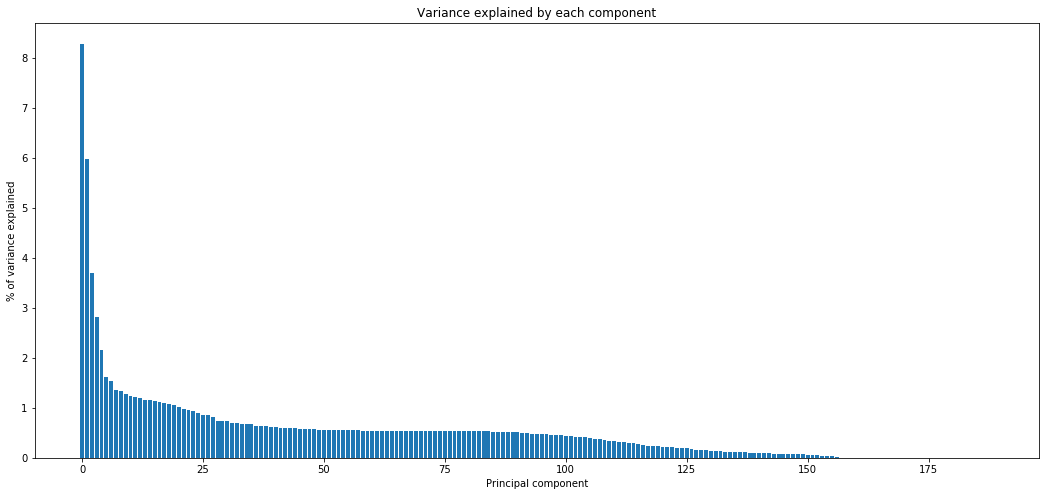

In [101]:
# Investigate the variance accounted for by each principal component.
plt.figure(figsize=(18, 8))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_*100)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("% of variance explained")
plt.show()

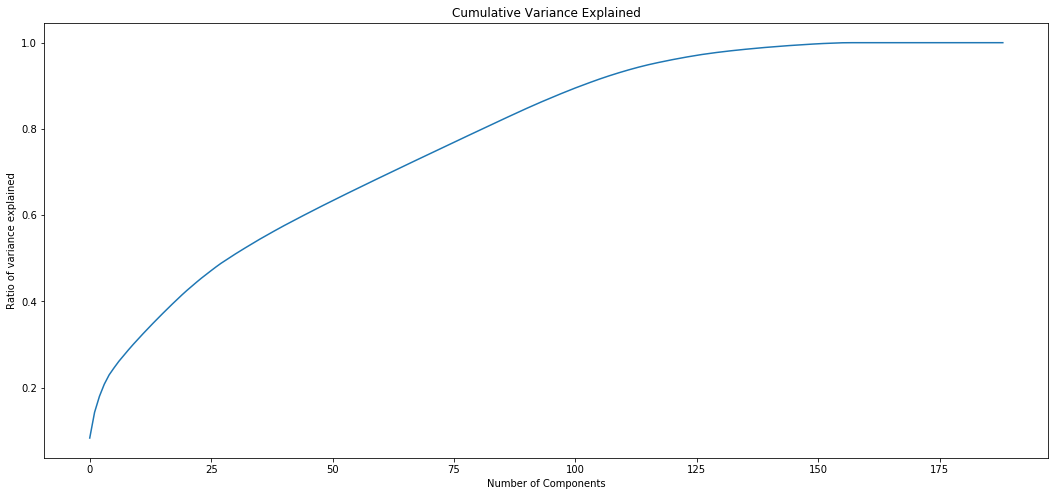

In [102]:
plt.figure(figsize=(18, 8))
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.show()

In [103]:
pca.explained_variance_ratio_[:60].sum()

0.6830188949702098

In [104]:
for i in np.arange(10, 81, 10):
    print('{} components explain {} of variance.'.format(i, pca.explained_variance_ratio_[:i].sum()))

10 components explain 0.30056683571887743 of variance.
20 components explain 0.414959945055261 of variance.
30 components explain 0.5026904982019783 of variance.
40 components explain 0.5693523960764817 of variance.
50 components explain 0.6278302467025916 of variance.
60 components explain 0.6830188949702098 of variance.
70 components explain 0.7369081975241657 of variance.
80 components explain 0.7902142644914876 of variance.


In [105]:
# Re-apply PCA to the data while selecting for number of components to retain.

# Looks like we need 60 principal components to explain around 70% of variability
pca = PCA(n_components=60)
azdias_pca = pca.fit_transform(azdias_std)

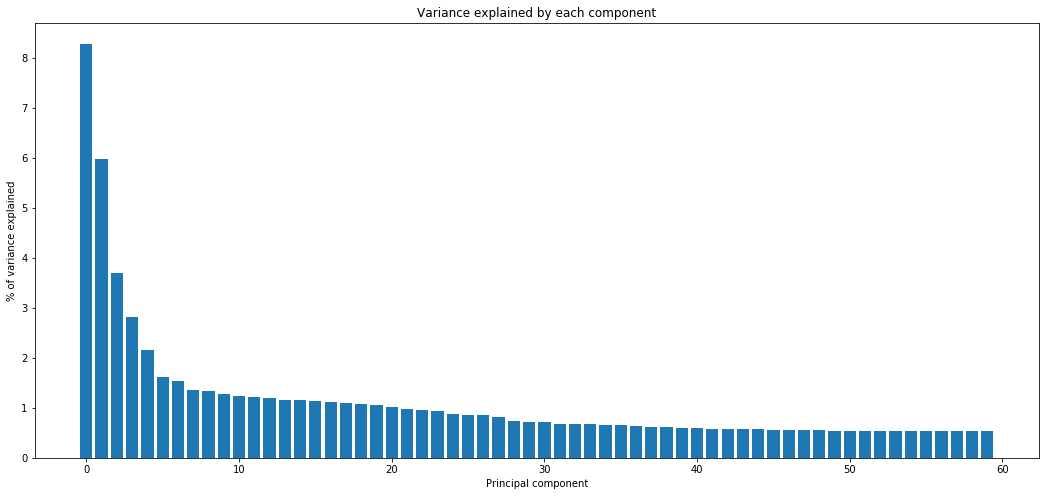

In [106]:
plt.figure(figsize=(18, 8))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_*100)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("% of variance explained")
plt.show()

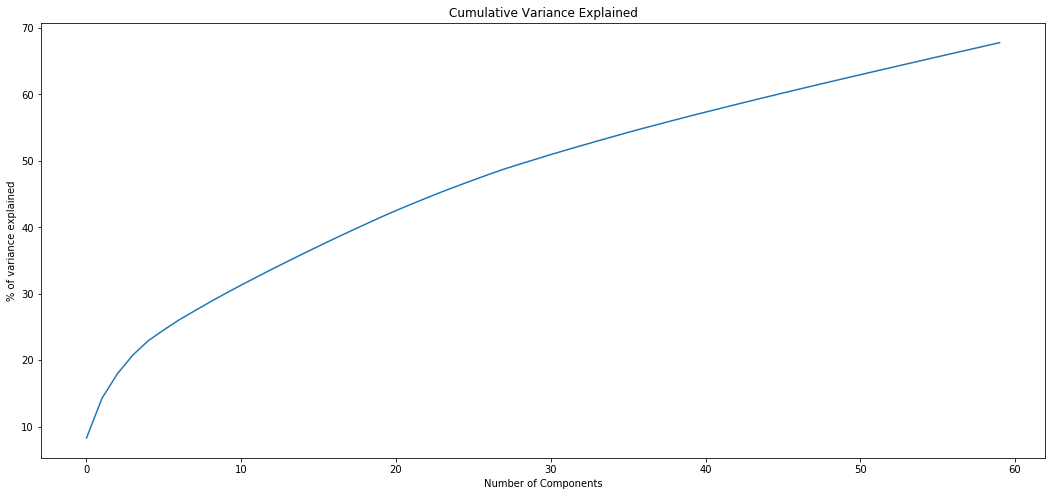

In [107]:
plt.figure(figsize=(18, 8))
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_*100), '-')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("% of variance explained")
plt.show()

#### Discussion 2.2: Perform Dimensionality Reduction
---
#### Derek's Notes

- I decided to retain 60 principal components, as it expalains around 70% variances while reducing the number of features by more than 50%.
----

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [108]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weights(df, pca, component_no, feature_no, show_plot=True):
    df = pd.DataFrame(pca.components_, columns=list(df.columns))
    weights = df.iloc[component_no].sort_values(ascending=False)
    weights = pd.concat([weights.head(feature_no), weights.tail(feature_no)])
    if show_plot:
        # Plot the result
        weights.plot(kind='bar', 
                  title='Most {} weighted features for PCA component #{}'.format(feature_no*2, component_no),
                  figsize=(12, 6))
        plt.show()    
    return weights


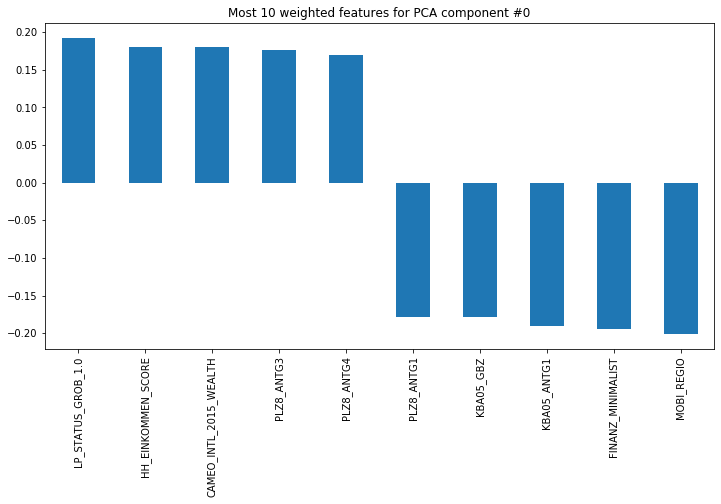

LP_STATUS_GROB_1.0        0.192304
HH_EINKOMMEN_SCORE        0.180725
CAMEO_INTL_2015_WEALTH    0.179924
PLZ8_ANTG3                0.175708
PLZ8_ANTG4                0.170157
PLZ8_ANTG1               -0.178187
KBA05_GBZ                -0.178340
KBA05_ANTG1              -0.190060
FINANZ_MINIMALIST        -0.194795
MOBI_REGIO               -0.201551
Name: 0, dtype: float64

In [109]:
# Map weights for the 1st principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(azdias_std, pca, 0, 5, True)

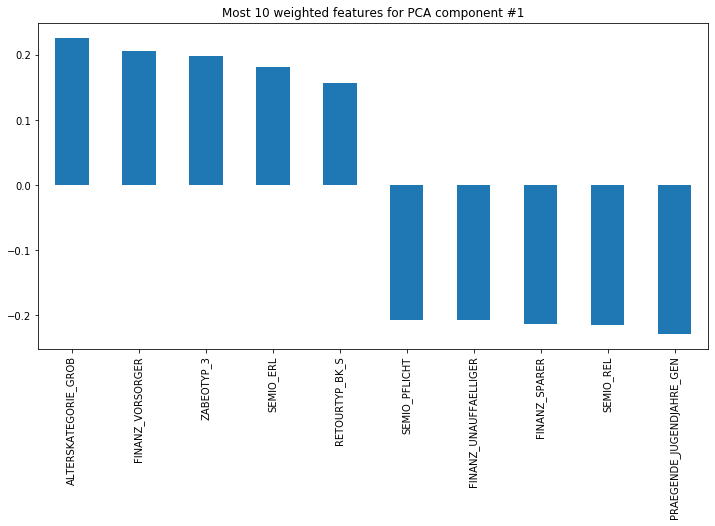

ALTERSKATEGORIE_GROB         0.226853
FINANZ_VORSORGER             0.205693
ZABEOTYP_3                   0.199096
SEMIO_ERL                    0.182274
RETOURTYP_BK_S               0.156595
SEMIO_PFLICHT               -0.206644
FINANZ_UNAUFFAELLIGER       -0.207237
FINANZ_SPARER               -0.213309
SEMIO_REL                   -0.215461
PRAEGENDE_JUGENDJAHRE_GEN   -0.229061
Name: 1, dtype: float64

In [110]:
# Map weights for the 2nd principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(azdias_std, pca, 1, 5, True)


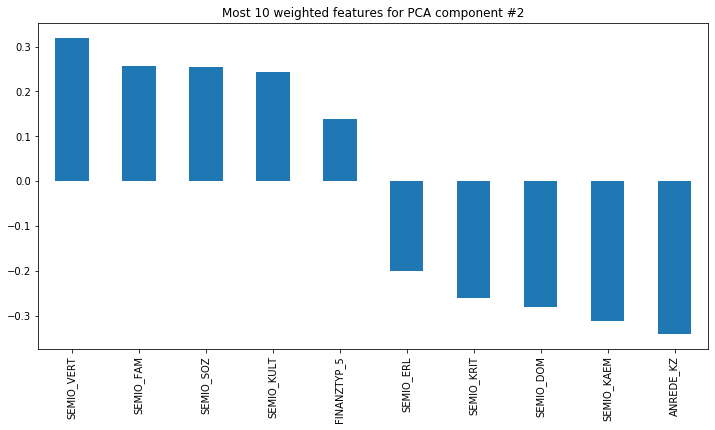

SEMIO_VERT     0.319916
SEMIO_FAM      0.257917
SEMIO_SOZ      0.255302
SEMIO_KULT     0.243485
FINANZTYP_5    0.139486
SEMIO_ERL     -0.199488
SEMIO_KRIT    -0.259573
SEMIO_DOM     -0.279709
SEMIO_KAEM    -0.312348
ANREDE_KZ     -0.341359
Name: 2, dtype: float64

In [111]:
# Map weights for the 3rd principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(azdias_std, pca, 2, 5, True)


#### Discussion 2.3: Interpret Principal Components

-----
#### Derek's notes

#### Dimension 1 -- it seems that this dimension is mostly related income, wealth and development

- LP_STATUS_GROB_1.0        = 0.192304  = Social status, rough scale - 1: low-income earners
- HH_EINKOMMEN_SCORE        = 0.180725  = Estimated household net income
- CAMEO_INTL_2015_WEALTH    = 0.179924  = German CAMEO: Wealth, mapped to international code
- PLZ8_ANTG3                = 0.175708  = Number of 1-2 family houses in the PLZ8 region - 3: high share of 3-5 family homes
- PLZ8_ANTG4                = 0.170157  = Number of 1-2 family houses in the PLZ8 region - 4: very high share of 3-5 family homes
- PLZ8_ANTG1               = -0.178187  = Number of 1-2 family houses in the PLZ8 region - 1: lower share of 3-5 family homes
- KBA05_GBZ                = -0.178340  = Number of buildings in the microcell
- KBA05_ANTG1              = -0.190060  = Number of 1-2 family houses in the microcell
- FINANZ_MINIMALIST        = -0.194795  = Financial typology, for each dimension
- MOBI_REGIO               = -0.201551  = Movement patterns

#### Dimension 2 -- this is more related to personality and age and some financial background

- ALTERSKATEGORIE_GROB         = 0.226853  = Estimated age based on given name analysis
- FINANZ_VORSORGER             = 0.205693  = Financial typology, for each dimension
- ZABEOTYP_3                   = 0.199096  = Energy consumption typology
- SEMIO_ERL                    = 0.182274  = Personality typology, for each dimension:
- RETOURTYP_BK_S               = 0.156595  = Return type
- SEMIO_PFLICHT               = -0.206644  = Personality typology
- FINANZ_UNAUFFAELLIGER       = -0.207238  = Financial typology
- FINANZ_SPARER               = -0.213310  = Financial typology
- SEMIO_REL                   = -0.215461  = Personality typology
- PRAEGENDE_JUGENDJAHRE_GEN   = -0.229061  = Dominating movement of person's youth - Generation

#### Dimension 3 -- this is mostly personality related 

- SEMIO_VERT     = 0.319916  = Personality typology
- SEMIO_FAM      = 0.257917  = Personality typology
- SEMIO_SOZ      = 0.255302  = Personality typology
- SEMIO_KULT     = 0.243485  = Personality typology
- FINANZTYP_5    = 0.139486  = Most descriptive financial type for individual - investor
- SEMIO_ERL     = -0.199488  = Personality typology
- SEMIO_KRIT    = -0.259573  = Personality typology
- SEMIO_DOM     = -0.279709  = Personality typology
- SEMIO_KAEM    = -0.312348  = Personality typology
- ANREDE_KZ     = -0.341359  = Gender

-----

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [112]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.

def get_kmeans_score(data, clusters):
    kmeans = KMeans(n_clusters=clusters)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

scores = []
clusters = list(range(1,20))
for k in clusters:
    scores.append(get_kmeans_score(azdias_pca, k))
    

Text(0.5, 1.0, 'SSE vs. K')

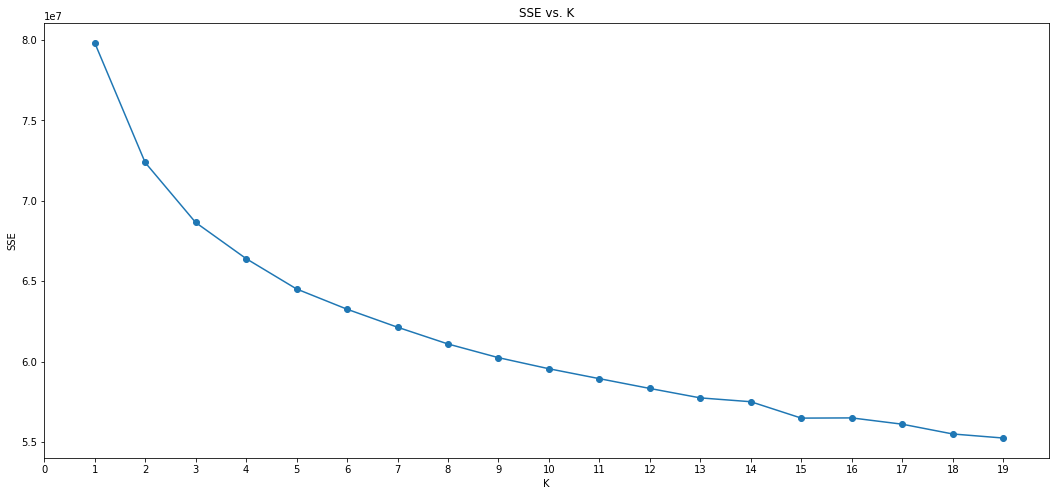

In [113]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(18, 8))
plt.plot(clusters, scores, linestyle='-', marker='o')
plt.xticks(np.arange(0, 20, step=1))
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')

In [114]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 10)
model_10 = kmeans.fit(azdias_pca)
azdias_pred = model_10.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population
---
#### Derek's notes

- From the above plot, I dont really see an elbow. But I thought picking 10 clusters is a good middle.
------

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [115]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [116]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

In [117]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)
customers_std = scaler.fit_transform(customers_clean)
customers_pca = pca.fit_transform(customers_std)
customers_pred = model_10.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5, 1.0, 'General Clusters')

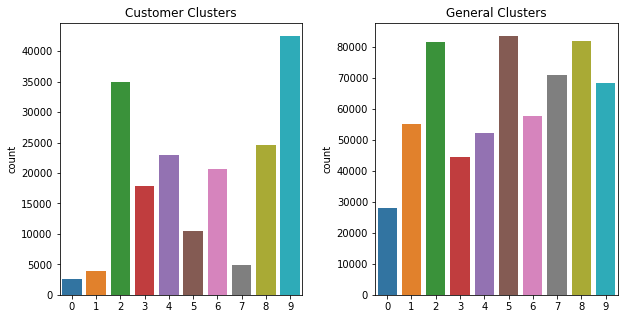

In [118]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(customers_pred, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(azdias_pred, ax=axs[1])
axs[1].set_title('General Clusters')

In [119]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_6 = scaler.inverse_transform(pca.inverse_transform(model_10.cluster_centers_[6]))
overrepresented_c = pd.Series(data = centroid_6, index = customers_clean.columns)
overrepresented_c

ALTERSKATEGORIE_GROB     3.217134
ANREDE_KZ                0.952187
FINANZ_MINIMALIST        4.997164
FINANZ_SPARER            1.537129
FINANZ_VORSORGER         4.624273
FINANZ_ANLEGER           1.969256
FINANZ_UNAUFFAELLIGER    2.356538
FINANZ_HAUSBAUER         2.154135
GREEN_AVANTGARDE         0.612902
RETOURTYP_BK_S           4.367533
SEMIO_SOZ                4.312488
SEMIO_FAM                5.216963
SEMIO_REL                4.340040
SEMIO_MAT                4.411104
SEMIO_VERT               5.058328
SEMIO_LUST               6.044711
SEMIO_ERL                3.081791
SEMIO_KULT               4.537203
SEMIO_RAT                2.582996
SEMIO_KRIT               3.360645
SEMIO_DOM                3.454822
SEMIO_KAEM               2.700246
SEMIO_PFLICHT            3.022426
SEMIO_TRADV              2.554477
HH_EINKOMMEN_SCORE       1.554305
ONLINE_AFFINITAET        2.797216
CJT_GESAMTTYP_1.0        0.210863
CJT_GESAMTTYP_2.0        0.149702
CJT_GESAMTTYP_3.0        0.346080
CJT_GESAMTTYP_

In [120]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid_0 = scaler.inverse_transform(pca.inverse_transform(model_10.cluster_centers_[0]))
underrepresented_c = pd.Series(data = centroid_0, index = customers_clean.columns)
underrepresented_c

ALTERSKATEGORIE_GROB     3.724237
ANREDE_KZ                1.574490
FINANZ_MINIMALIST        4.138186
FINANZ_SPARER            1.398154
FINANZ_VORSORGER         4.196859
FINANZ_ANLEGER           1.115610
FINANZ_UNAUFFAELLIGER    1.278814
FINANZ_HAUSBAUER         2.661490
GREEN_AVANTGARDE         0.644392
RETOURTYP_BK_S           3.362315
SEMIO_SOZ                3.977812
SEMIO_FAM                2.651506
SEMIO_REL                2.085414
SEMIO_MAT                3.324291
SEMIO_VERT               5.615696
SEMIO_LUST               3.943325
SEMIO_ERL                5.031803
SEMIO_KULT               3.791214
SEMIO_RAT                3.242516
SEMIO_KRIT               4.010634
SEMIO_DOM                4.478734
SEMIO_KAEM               3.613187
SEMIO_PFLICHT            2.911881
SEMIO_TRADV              3.585205
HH_EINKOMMEN_SCORE       3.789848
ONLINE_AFFINITAET        3.601028
CJT_GESAMTTYP_1.0       -0.021735
CJT_GESAMTTYP_2.0        0.762683
CJT_GESAMTTYP_3.0        0.028278
CJT_GESAMTTYP_

### Discussion 3.3: Compare Customer Data to Demographics Data
---
#### Derek's notes:

- Cluster 6 is overrepresented in the customers data compared to general population data.

- Cluster 0 is underrepresented in the customers data.
---

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.